# Conditional GMM
Created by: Daniel L. Marino (marinodl@vcu.edu)

Description: gaussian mixture model implementation on tensorflow, the objective is a conditional probabilistic distribution. 

This file serves as a visual test for the gmm extension modules

In [1]:
import tensorflow as tf
import numpy as np
import math
import collections
from twodlearn.tf_lib.datasets.generic import Datasets
import twodlearn.tf_lib.GMM as GMM

%matplotlib inline
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## 1. Create dataset

In [2]:

def gmm_sampling(mu, sigma, w, n_samples=1):
    # generates random vectors, sampled from a gausian mixture model
    #  
    #     - mu: 3d tensor containing the means for the gaussians.
    #           the "depth" dimention (3rd) is used to index the
    #           gaussians.    [ kernel_id, dim]
    #     - sigma: 3d tensor containing the covariance matrix of the
    #              gaussians. [ kernel_id, dim] for diagonal matrices
    #     - w: vector in form of a 3d tensor containing the weights
    #          for each one of the gaussians, they have to sum one. 
    #          [kernel_id]
    n_kernels = mu.shape[0]
    n_dim = mu.shape[1]
    
    # random sample the kernel from which the output samples are going
    # to be drawn
    kernel_id= np.argmax(np.random.multinomial(1, w, size=[n_samples]), axis=1 )
    
    out = np.zeros([n_samples, n_dim])
    for i in range(n_samples):
        out[i,:]= np.random.multivariate_normal(mu[kernel_id[i],:], np.diag(sigma[kernel_id[i],:])) # if diagonal
    
    return out;
    
    

Data shape:  (1000,)


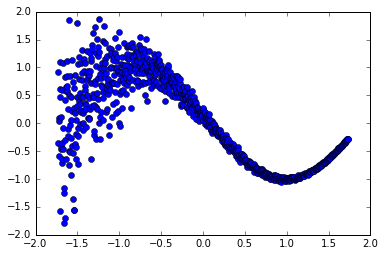

In [3]:
n_samples = 1000

sigma_r = 1.0*np.exp(-0.005*np.linspace(0, n_samples, n_samples))
w_r = [1]  # has to sum to one

aux_x= np.linspace(0, 6, n_samples)
aux_y= np.linspace(0, 6, n_samples)

for i in range(n_samples):
    aux_y[i] = np.random.normal(np.sin( aux_x[i] ), sigma_r[i])

# build the dataset
data = Datasets(aux_x, aux_y)
data.normalize()
print('Data shape: ', data.train.x.shape)

# plot
plt.plot(data.train.x, data.train.y, 'o')

In [4]:
print(np.sin(aux_x[2]))

0.0120117231484


## 2. Model definition

In [5]:
sess = tf.InteractiveSession()

In [6]:
n_inputs = 1
n_outputs = 1
n_hidden= [4]
n_kernels = 1


gmm_model = GMM.GmmSBoundedMlpModel( n_inputs, n_outputs, n_hidden, n_kernels, afunction= tf.sigmoid, diagonal= True)

train_model= gmm_model.setup(n_samples)

In [7]:
# Optimizer.
optimizer = tf.train.AdamOptimizer(0.005).minimize(train_model.loss + 100.0*tf.inv(tf.mul(GMM.global_test, GMM.global_test)) ) #0.001
#optimizer = tf.train.AdamOptimizer(0.005).minimize(train_model.loss ) #0.001

In [8]:
print('mu shape:', train_model.mu.get_shape())
print('sigma shape:', train_model.sigma.get_shape())
print('w shape:', train_model.w.get_shape())

print('out shape:', train_model.out.get_shape())

print('loss shape:', train_model.loss.get_shape())


mu shape: (1000, 1, 1)
sigma shape: (1000, 1, 1)
w shape: (1000, 1)
out shape: (1000,)
loss shape: ()


## 3. Training

In [9]:
tf.initialize_all_variables().run()
print('Initialized')

Initialized


In [10]:
[mu_out, sigma_out, w_out, test] = sess.run([ train_model.mu, train_model.sigma, train_model.w, GMM.global_test ],
                                         feed_dict= {train_model.inputs : np.expand_dims(data.train.x, 1)})

print(sigma_out.shape)
print(test.shape)
print(test)

(1000, 1, 1)
(1, 1)
[[-0.07525764]]


In [11]:
num_steps = 5000 #1000
n_logging = 100
n_test_logg = 10

tf.initialize_all_variables().run()
print('Initialized')

mean_loss= 0
train_accuracy= 0
for step in range(num_steps):   
    
    _, l = sess.run([optimizer, train_model.loss],feed_dict={train_model.inputs : np.expand_dims(data.train.x,1),
                                                             train_model.labels : np.expand_dims(data.train.y,1)})
    mean_loss += l    
    
    
    if step%n_logging == 0:                
        print(step, ' | loss:', mean_loss/n_logging)
        mean_loss= 0

Initialized
0  | loss: 20.9024780273
100  | loss: 1580.87509644
200  | loss: 729.551602783
300  | loss: 425.769761047
400  | loss: 129.541294937
500  | loss: -262.703236008
600  | loss: -1131.20303467
700  | loss: -1775.41689697
800  | loss: -1889.76561768
900  | loss: -1921.30447144
1000  | loss: -1941.00769653
1100  | loss: -1960.13178101
1200  | loss: -1977.48936279
1300  | loss: -1994.07738159
1400  | loss: -2009.95504761
1500  | loss: -2023.76620972
1600  | loss: -2038.19729858
1700  | loss: -2050.65787231
1800  | loss: -2064.20087646
1900  | loss: -2075.68111816
2000  | loss: -2088.73540771
2100  | loss: -2099.57600586
2200  | loss: -2112.21428467
2300  | loss: -2122.70548096
2400  | loss: -2134.88047852
2500  | loss: -2145.01369385
2600  | loss: -2156.7935083
2700  | loss: -2166.19837646
2800  | loss: -2177.77998291
2900  | loss: -2186.68371094
3000  | loss: -2197.80366699
3100  | loss: -2207.40137451
3200  | loss: -2216.33595947
3300  | loss: -2225.71133789
3400  | loss: -2235.

## 4. Plot

In [12]:
# model for testing
n_test= 100;
test_model = gmm_model.setup(n_test)


(100,)
(100,)


<IPython.core.display.Javascript object>


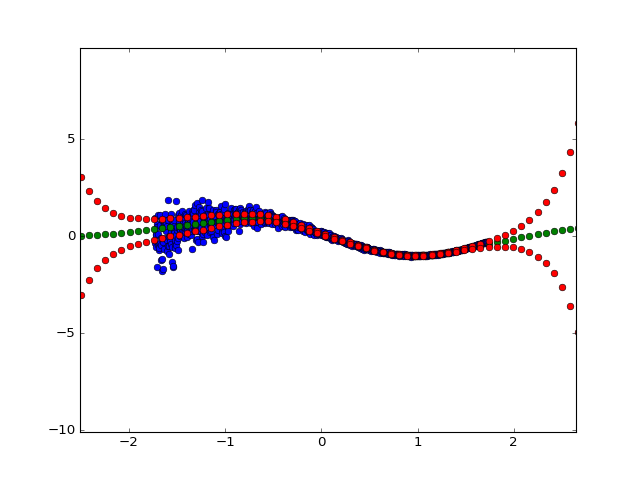

(100, 1, 1)


In [13]:
%matplotlib notebook

x_plot = np.linspace(-4.2, 4.2, n_test)

[mu_out, sigma_out, w_out,] = sess.run([ test_model.mu, test_model.sigma, test_model.w ],
                                         feed_dict= {test_model.inputs : np.expand_dims(x_plot, 1)})
#print('mu:', mu_out, 'sigma:', sigma_out, 'w:', w_out)

print(np.squeeze(mu_out).shape)
print(x_plot.shape)

# plot
plt.plot(data.train.x, data.train.y, 'o')
plt.plot(x_plot, np.squeeze(mu_out), 'o')

plt.plot(x_plot, np.squeeze(mu_out) + np.squeeze(np.sqrt(sigma_out)), 'ro')
plt.plot(x_plot, np.squeeze(mu_out) - np.squeeze(np.sqrt(sigma_out)), 'ro')

print(sigma_out.shape)

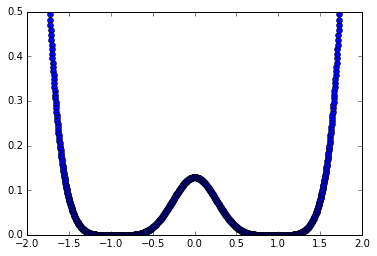

In [33]:
%matplotlib inline
#
# Function design. 
#
plt.plot(data.train.x, 
         np.power((1/( np.exp( -np.power(((1.0*data.train.x)+1), 2.0) )
                       + np.exp( -np.power(((1.0*data.train.x)-1), 2.0) )))-1, 2.0)
         
         , 'o')

## Maximization over L_sigma

In [34]:
L_sigma_optimizer = tf.train.AdamOptimizer(0.005).minimize( 
    ( tf.pow((-1.0*2791.0 - train_model.loss), 2.0)), var_list=[GMM.global_test]  ) #0.001

In [35]:
num_steps = 5000 #1000
n_logging = 100
n_test_logg = 10

tf.initialize_all_variables().run()
print('Initialized')

mean_loss= 0
train_accuracy= 0
for step in range(num_steps):   
    
    _, l = sess.run([L_sigma_optimizer, train_model.loss],feed_dict={train_model.inputs : np.expand_dims(data.train.x,1),
                                                             train_model.labels : np.expand_dims(data.train.y,1)})
    mean_loss += l    
    
    
    if step%n_logging == 0:                
        print(step, ' | loss:', mean_loss/n_logging)
        mean_loss= 0

Initialized
0  | loss: 20.6354345703
100  | loss: 2063.5432666
200  | loss: 2063.54327881
300  | loss: 2063.54327148
400  | loss: 2063.54325684
500  | loss: 2063.54326172
600  | loss: 2063.54326416
700  | loss: 2063.54326904
800  | loss: 2063.54327393
900  | loss: 2063.54329346
1000  | loss: 2063.54328613
1100  | loss: 2063.54328125
1200  | loss: 2063.54327637
1300  | loss: 2063.54326172
1400  | loss: 2063.5432666
1500  | loss: 2063.54327637
1600  | loss: 2063.54327148
1700  | loss: 2063.54326904
1800  | loss: 2063.54327881
1900  | loss: 2063.54326416
2000  | loss: 2063.54327393
2100  | loss: 2063.54327148
2200  | loss: 2063.54329102
2300  | loss: 2063.54326904
2400  | loss: 2063.54327637
2500  | loss: 2063.54326416
2600  | loss: 2063.54328125
2700  | loss: 2063.54327148
2800  | loss: 2063.54325928
2900  | loss: 2063.54325928
3000  | loss: 2063.54327148
3100  | loss: 2063.54326172
3200  | loss: 2063.54327393
3300  | loss: 2063.54326416
3400  | loss: 2063.54325439
3500  | loss: 2063.543

(100,)
(100,)


<IPython.core.display.Javascript object>


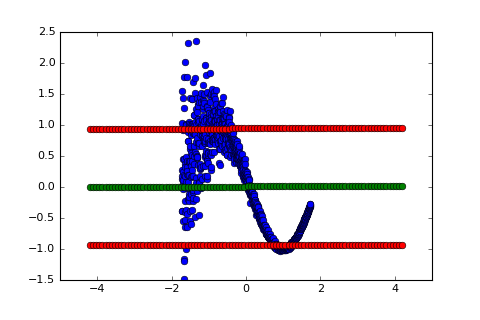

(100, 1, 1)


In [36]:
%matplotlib notebook

x_plot = np.linspace(-4.2, 4.2, n_test)

[mu_out, sigma_out, w_out,] = sess.run([ test_model.mu, test_model.sigma, test_model.w ],
                                         feed_dict= {test_model.inputs : np.expand_dims(x_plot, 1)})
#print('mu:', mu_out, 'sigma:', sigma_out, 'w:', w_out)

print(np.squeeze(mu_out).shape)
print(x_plot.shape)

# plot
plt.plot(data.train.x, data.train.y, 'o')
plt.plot(x_plot, np.squeeze(mu_out), 'o')

plt.plot(x_plot, np.squeeze(mu_out) + np.squeeze(np.sqrt(sigma_out)), 'ro')
plt.plot(x_plot, np.squeeze(mu_out) - np.squeeze(np.sqrt(sigma_out)), 'ro')

print(sigma_out.shape)